In [1]:
import requests
import pandas as pd
import json
import numpy as np


# Setup pitch and plot
from mplsoccer.pitch import Pitch ,VerticalPitch

username = "XXX"
password = "XXX"


from skillcorner.client import SkillcornerClient
client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s


# black .


### Extract Tracking Data

In [2]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the pyton client
###------------------------------------------------------------------------------------
# match_id=1886347
# client.save_match_tracking_data(match_id,
#                                 params={'data_version':3},
#                                 filepath=f'{match_id}_tracking_raw.jsonl')

####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
match_id = 1886347
# raw_data = pd.read_json(
#     f"../sample_data/{match_id}_tracking_extrapolated.jsonl", lines=True
# )

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------

# # Construct the raw GitHub URL
tracking_data_github_url=f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl' # Data is stored using GitLFS
raw_data=pd.read_json(tracking_data_github_url,lines=True)


raw_df = pd.json_normalize(
    raw_data.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)

# Extract 'player_id' and 'group from the 'possession' dictionary
raw_df["possession_player_id"] = raw_df["possession"].apply(
    lambda x: x.get("player_id")
)
raw_df["possession_group"] = raw_df["possession"].apply(lambda x: x.get("group"))


# (Optional) Expand the ball_data with json_normalize
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(
    raw_df.ball_data
)


# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=["possession", "ball_data"])

# Add the match_id identifier to your dataframe
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()
tracking_df.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.63,-0.08,51009,False,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
1,-19.21,-9.18,176224,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
2,-21.83,0.47,51649,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
3,-1.16,-32.47,50983,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
4,-18.88,15.73,735578,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347


### Extract MetaData

In [3]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the python client
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_match_data=client.get_match(match_id)


####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
# match_id = 1886347
# file_path = f"../../data/matches/{match_id}/{match_id}_match.json"

# with open(file_path, "r") as f:
#     raw_match_data = json.load(f)

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------
match_id=1886347
meta_data_github_url=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json'
# Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()


# The output has nested json elements. We process them
raw_match_df = pd.json_normalize(raw_match_data, max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    raw_match_df.to_dict("records"),
    record_path="players",
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],  # data we keep
)


# Take only players who played and create their total time
players_df = players_df[
    ~((players_df.start_time.isna()) & (players_df.end_time.isna()))
]
players_df["total_time"] = players_df["end_time"].apply(time_to_seconds) - players_df[
    "start_time"
].apply(time_to_seconds)

# Create a flag for GK
players_df["is_gk"] = players_df["player_role.acronym"] == "GK"

# Add a flag if the given player is home or away
players_df["match_name"] = (
    players_df["home_team.name"] + " vs " + players_df["away_team.name"]
)


# Add a flag if the given player is home or away
players_df["home_away_player"] = np.where(
    players_df.team_id == players_df["home_team.id"], "Home", "Away"
)

# Create flag from player
players_df["team_name"] = np.where(
    players_df.team_id == players_df["home_team.id"],
    players_df["home_team.name"],
    players_df["away_team.name"],
)

# Figure out sides
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)
# Clean up sides
players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_1st_half,
    players_df.home_team_side_2nd_half,
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_2nd_half,
    players_df.home_team_side_1st_half,
)


# Clean up and keep the columns that we want to keep about

columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep]
players_df.head()

,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,00:00:00,01:25:21,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,38673,G. May,10,4177,Auckland FC,Center Forward,5121,Center Forward,CF,False,right_to_left,left_to_right
1,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51713,C. Elliott,17,4177,Auckland FC,Full Back,5400,Right Back,RB,False,right_to_left,left_to_right
2,00:00:00,01:16:37,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50951,J. Brimmer,22,4177,Auckland FC,Center Forward,4597,Center Forward,CF,False,right_to_left,left_to_right
3,00:00:00,01:24:58,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50978,C. Timmins,19,1805,Newcastle United Jets FC,Midfield,5098,Left Defensive Midfield,LDM,False,left_to_right,right_to_left
4,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,133498,F. De Vries,15,4177,Auckland FC,Full Back,5400,Left Back,LB,False,right_to_left,left_to_right


### Merge Dataframes

In [4]:
# Merging datasets
enriched_tracking_data = tracking_df.merge(
    players_df, left_on=["player_id"], right_on=["id"]
)
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.63,-0.08,51009,False,10,2025-10-26,1.0,NaN,None,0.32,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-19.21,-9.18,176224,True,10,2025-10-26,1.0,NaN,None,0.32,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,-21.83,0.47,51649,True,10,2025-10-26,1.0,NaN,None,0.32,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-1.16,-32.47,50983,True,10,2025-10-26,1.0,NaN,None,0.32,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-18.88,15.73,735578,True,10,2025-10-26,1.0,NaN,None,0.32,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


In [11]:
enriched_tracking_data['possession_player_id'].unique()

array([    nan, 966120.,  51649.,  23418.,  33697., 133498.,  50983.,
       965685.,  51009., 735578.,  51713.,  14736.,  50978., 176224.,
       735573., 795505., 735574.,  50951.,  38673.,  51667., 285188.,
       795507., 133501., 560992., 795506.,  43829., 163972., 797297.,
       800320.,  31147.])

In [13]:
# use bitwise & and parentheses when combining boolean masks in pandas
enriched_tracking_data[
	(enriched_tracking_data["possession_player_id"] == 966120)
	& (enriched_tracking_data["frame"] == 28)
]

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
396,-40.71,-0.27,51009,False,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
397,-19.33,-9.63,176224,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
398,-21.72,0.22,51649,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
399,-0.64,-33.03,50983,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
400,-20.11,15.75,735578,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left
401,-6.52,6.95,50978,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,19,1805,Newcastle United Jets FC,Midfield,5098,Left Defensive Midfield,LDM,False,left_to_right,right_to_left
402,-9.58,-5.04,735574,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,17,1805,Newcastle United Jets FC,Midfield,5400,Right Defensive Midfield,RDM,False,left_to_right,right_to_left
403,-0.15,8.15,795507,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,37,1805,Newcastle United Jets FC,Midfield,3615,Attacking Midfield,AM,False,left_to_right,right_to_left
404,-1.09,-20.49,795505,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,7,1805,Newcastle United Jets FC,Wide Attacker,5098,Right Winger,RW,False,left_to_right,right_to_left
405,-1.08,18.69,735573,True,28,2025-10-26 00:00:01.800,1.0,966120.0,away team,0.03,...,39,1805,Newcastle United Jets FC,Wide Attacker,5400,Left Winger,LW,False,left_to_right,right_to_left


### Plot

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def plot_tracking_frame(enriched_data, frame_num, delay=0.1):
    """
    Plot a single frame of tracking data on a football pitch
    
    Parameters:
    - enriched_data: DataFrame with enriched tracking data
    - frame_num: Frame number to plot
    - delay: Delay between frames (for animation effect)
    """
    # Filter data for specific frame
    frame_data = enriched_data[enriched_data['frame'] == frame_num]
    
    if frame_data.empty:
        print(f"No data found for frame {frame_num}")
        return
    
    # Create pitch
    pitch = Pitch(
        pitch_type="skillcorner",
        line_alpha=0.75,
        pitch_length=105,
        pitch_width=68,
        pitch_color="#001400",
        line_color="white",
        linewidth=1.5,
    )
    
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Plot players by team
    size = 300
    
    # Get unique teams in this frame
    teams = frame_data['team_name'].unique()
    colors = ['#084D42', '#E51717']  # Green for team 1, Red for team 2
    
    for i, team in enumerate(teams):
        team_data = frame_data[frame_data['team_name'] == team]
        
        # Regular players
        regular_players = team_data[team_data['is_gk'] == False]
        ax.scatter(
            regular_players['x'],
            regular_players['y'],
            c=colors[i % len(colors)],
            alpha=0.95,
            s=size,
            edgecolors='white',
            linewidths=1.5,
            zorder=10,
            label=team
        )
        
        # Goalkeepers (different marker)
        goalkeepers = team_data[team_data['is_gk'] == True]
        if not goalkeepers.empty:
            ax.scatter(
                goalkeepers['x'],
                goalkeepers['y'],
                c=colors[i % len(colors)],
                alpha=0.95,
                s=size * 1.2,
                edgecolors='yellow',
                linewidths=3,
                marker='s',  # Square marker for GK
                zorder=10,
                label=f'{team} GK'
            )
    
    # Plot ball if available
    if 'ball_x' in frame_data.columns and not frame_data['ball_x'].isna().all():
        ball_data = frame_data[['ball_x', 'ball_y']].dropna().iloc[0]
        ax.scatter(
            ball_data['ball_x'],
            ball_data['ball_y'],
            c='white',
            s=100,
            edgecolors='black',
            linewidths=2,
            zorder=15,
            label='Ball'
        )
    
    # Add frame info
    timestamp = frame_data['timestamp'].iloc[0] if 'timestamp' in frame_data.columns else 'N/A'
    period = frame_data['period'].iloc[0] if 'period' in frame_data.columns else 'N/A'
    
    ax.set_title(f'Frame: {frame_num} | Time: {timestamp} | Period: {period}', 
                fontsize=14, fontweight='bold', color='white')
    
    # Add legend
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.show()
    
    if delay > 0:
        time.sleep(delay)

def animate_tracking_data(enriched_data, start_frame=10, end_frame=100, delay=0.1):
    """
    Animate tracking data through multiple frames
    
    Parameters:
    - enriched_data: DataFrame with enriched tracking data
    - start_frame: Starting frame number
    - end_frame: Ending frame number
    - delay: Delay between frames in seconds
    """
    available_frames = sorted(enriched_data['frame'].unique())
    frames_to_plot = [f for f in available_frames if start_frame <= f <= end_frame]
    
    print(f"Animating {len(frames_to_plot)} frames from {start_frame} to {end_frame}")
    print("Available frames in range:", frames_to_plot[:10], "..." if len(frames_to_plot) > 10 else "")
    
    for frame_num in frames_to_plot:
        clear_output(wait=True)
        plot_tracking_frame(enriched_data, frame_num, delay=0)
        if delay > 0:
            time.sleep(delay)

# Example usage:
# animate_tracking_data(enriched_tracking_data, start_frame=10, end_frame=100, delay=0.2)

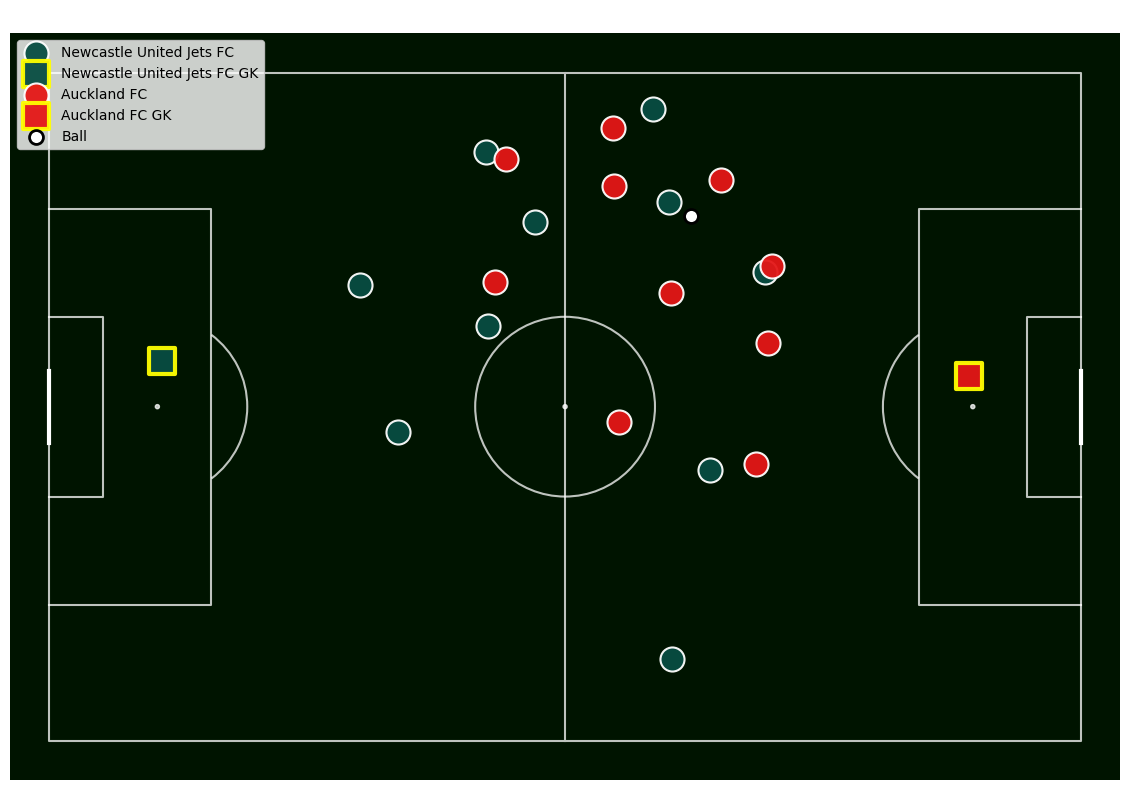

In [21]:
# Run the animation
animate_tracking_data(enriched_tracking_data, start_frame=10, end_frame=100, delay=0.001)